# Bayesian MSD analysis
The purpose of ``bayesmsd`` is to provide a statistically rigorous method for fitting MSD curves. Let's see how this works in practice; for a brief summary of the underlying ideas see [below](#Epilogue:-basic-ideas)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import bayesmsd

## Generating some example data
We start by generating a simple example data set of random walk trajectories: 20 trajectories, 100 frames each, in 2 spatial dimensions, generated by cumulatively adding standard normally distributed "steps".

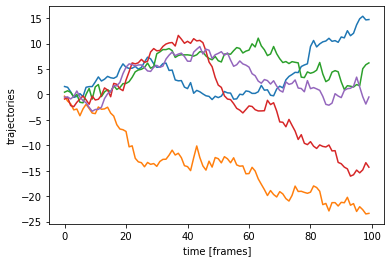

In [2]:
np.random.seed(704724568)
data = np.cumsum(np.random.normal(size=(20, 100, 2)), axis=1)

# Visualize a few random ones
for i in [0, 3, 7, 10, 18]:
    plt.plot(data[i, :, 0])
plt.xlabel('time [frames]')
plt.ylabel('trajectories')
plt.show()

We format the trajectories as a big numpy array of shape ``(trajectories, frames, dimensions)``, which is handy for this synthetic example. For more info on how to format data for use with ``bayesmsd``, see [below](#Epilogue:-data-formatting)

## Fitting a powerlaw MSD
A general powerlaw MSD has the form
\begin{equation}
\text{MSD}(\Delta t) = \Gamma (\Delta t)^\alpha\,.
\end{equation}
For our example data set we sampled the increments from a standard normal distribution; so we expect to see $\text{MSD}(\Delta t) = \Delta t$. Thus, both the exponent $\alpha$ and the prefactor $\Gamma$ ("anomalous diffusion constant") should be equal to one. Let's see what we find by fitting the data:

In [3]:
fit = bayesmsd.lib.NPXFit(data, ss_order=1)
fit.parameters['log(σ²) (dim 0)'].fix_to = -np.inf # data is synthetic, so
fit.parameters['log(σ²) (dim 1)'].fix_to = -np.inf # no localization error

fitres = fit.run(show_progress=True)

print(f"fitted exponent:  {       fitres['params'][     'α (dim 0)'] :.2f}")
print(f"fitted prefactor: {np.exp(fitres['params']['log(Γ) (dim 0)']):.2f}")


fitted exponent:  1.02
fitted prefactor: 1.01


This looks quite good; we can probably assume that the slight deviations from the theoretical values (1.00 for both exponent and prefactor) are statistical fluctuations due to finite data. But can we make a quantitative statement about that?

The Bayesian approach allows us to calculate credible intervals for the fit results; this is the job of the ``Profiler`` class:

In [4]:
profiler = bayesmsd.Profiler(fit)
profiler.point_estimate = fitres

mci = profiler.find_MCI(show_progress=True)

m, ci = mci['α (dim 0)']
print(f"fitted exponent:  {m:.2f}, with 95% CI: [{ci[0]:.2f}, {ci[1]:.2f}]")

m, ci = mci['log(Γ) (dim 0)']
print(f"fitted prefactor: {np.exp(m):.2f}, with 95% CI: [{np.exp(ci[0]):.2f}, {np.exp(ci[1]):.2f}]")


fitted exponent:  1.02, with 95% CI: [0.98, 1.06]
fitted prefactor: 1.01, with 95% CI: [0.97, 1.06]


Indeed, our theoretical expectations lie well within the credible interval of the fit. So we can conclude that standard normal diffusion is consistent with the trajectories in ``data``.

## Understanding what just happened
Let us understand the two code blocks above in some more detail.

 + We begin by creating an instance of the ``bayesmsd.lib.NPXFit`` class. ``NPX`` stands for "``N``oise + ``P``owerlaw + ``X``"; its core is the ``P``, i.e. fitting a powerlaw $\text{MSD} = \Gamma(\Delta t)^\alpha$ to the data.
 + The keyword argument ``ss_order=1`` tells the fit object that we are looking at increment stationary trajectories, as opposed to trajectories that are themselves stationary (in which case we would set ``ss_order=0``; see [below](#Epilogue:-ss_order) for more details).
 + By default, ``NPXFit`` includes a ``N``oise floor (i.e. localization error) in its fit; since our data are synthetic diffusion—without any error added—we do not want the fit to have that free parameter. The second line
 
   ```py
   fit.parameters['log(σ²) (dim 0)'].fix_to = -np.inf
   ```
   
   tells our ``fit`` object to keep the parameter named ``'log(σ²) (dim 0)'`` (the log of the squared localization error along the $x$ axis) fixed to the constant value ``-np.inf``, instead of trying to fit it to the data.
 + Line 3 achieves the same along the $y$ axis (remember that our data has two spatial dimensions)
 + The ``X`` of ``NPXFit`` can be used to extend the powerlaw with cubic splines at long times; it is disabled by default and we will not worry about it at this point.
 + Finally, we execute the fit by calling  ``fit.run()``.
 + For now we are just interested in the best-fit (MAP) parameter values, so we print them.

The fit leaves us with a point estimate for the parameters $\Gamma$ and $\alpha$. One of the true powers of the Bayesian approach is that we can now also calculate error bars ("credible intervals"). The ``Profiler`` class does this by tracing out the *profile posterior* for each parameter. Here are the details on the second code block above:

 + We initalize a new ``Profiler`` instance. The profiler should be understood as sitting downstream of the fit, i.e. it uses the ``Fit`` object it is initialized on to execute all its tasks.
 + Since we already ran the fit, we know the point estimate for the parameters and hand it to the profiler. If ``profiler.point_estimate`` remains unspecified, the profiler will run the fit itself.
 + ``find_MCI()`` is the main function of the ``Profiler``. ``MCI`` stands for "``M``oint estimate and ``C``redible ``I``nterval" (``M`` for point estimate is a historical accident).

That's it for this quickstart example; we saw how to initialize and run a powerlaw fit, and how to use the profiler to calculate error bars. For more detailed introductions to the various features of ``bayesmsd``, browse the [Tutorials & Examples](../examples.rst), or see the [API reference](../bayesmsd.rst) for documentation of all the individual components.

## Epilogue: basic ideas
``bayesmsd`` does not actually fit MSD curves; instead, it works directly at the trajectory level:

+ Any given MSD curve (powerlaw or not) uniquely defines a steady state Gaussian process that exhibits this MSD;
+ given the Gaussian process, we can analytically calculate the likelihood of observing the given data;
+ this likelihood function then allows comparing different models (i.e. MSD curves) to each other and finding the one that best fits the data.
+ If we start out with a parametric family of MSD curves (e.g. a powerlaw: $\text{MSD}(\Delta t) = \Gamma(\Delta t)^\alpha$ would have two parameters $(\Gamma, \alpha)$), we can use Bayes' rule to calculate posterior distributions over the parameters. This provides us with rigorous estimates of uncertainty in the estimated values.

So at the end of the day, we find the **best fit Gaussian process to given data**. If the data can reasonably be assumed to be Gaussian, that seems to be the way to go of course; if the data is not Gaussian *per se*, we still get a best fit to second order (i.e. taking into account all two-point correlations).

## Epilogue: data formatting
How should data be formatted when handing them to a ``Fit`` object?

Above we used a big numpy array; while this was useful for synthetic data, it is not a particularly good format if trajectories can have different lengths. So what are the alternatives?

 + list of trajectories: a simple list of numpy arrays, each of shape ``(T, d)`` or ``(T,)`` where ``T`` is the number of frames and ``d`` the number of spatial dimensions. Missing frames can be indicated by ``np.nan``.
 + ``pandas.DataFrame``: a big data frame containing all individual data points can be formatted as follows: the column ``'particle'`` should contain a unique identifier for each trajectory; the column ``'frame'`` should contain integer frame numbers for all localizations; finally, coordinates for each localization should be in columns ``'x'``, ``'y'``, ``'z'`` (leave out ``'z'`` for 2D data, etc.)
 + ``noctiluca.TaggedSet``: under the hood, ``bayesmsd`` uses the [noctiluca](https://github.com/OpenTrajectoryAnalysis/noctiluca) library to format and handle single trajectories. ``TaggedSet`` is a data structure that can be used to dynamically aggregate different data sets and pick out specific subsets to work with. This is the natural data format for ``bayesmsd``; for details refer to the [noctiluca documentation](https://noctiluca.readthedocs.io/en/latest/index.html)
 + For more details see [noctiluca.util.userinput](https://noctiluca.readthedocs.io/en/latest/noctiluca.util.html#module-noctiluca.util.userinput), which is how ``bayesmsd`` deals with its input internally.

## Epilogue: ``ss_order``
**TL;DR:**

 + $\lim_{\Delta t\to\infty} \text{MSD}(\Delta t) < \infty \quad\Leftrightarrow\quad$ ``ss_order = 0``
 + $\lim_{\Delta t\to\infty} \text{MSD}(\Delta t) = \infty \quad\Leftrightarrow\quad$ ``ss_order = 1``
 
The parameter ``ss_order`` ("steady state order") controls an important distinction regarding the process that generates the data:

 + a steady state of order 0 means that the process generating the trajectories is itself in steady state. This is the case for example for a particle in a potential well (Ornstein-Uhlenbeck process), or any other process where the absolute coordinates carry some meaning
 + a steady state of order 1, in contrast, means that the generating process is *increment* stationary. This is the case for example for a standard random walk: the steps taken are drawn from a fixed distribution. Meanwhile, the absolute position of the walker carries no meaning (it will walk off to infinity in the long run either way).
 
Practically, the relevant question is: "does anything change, if I add 10 to all points in the trajectory?" (or, for that matter, if it is relevant "10" of which unit we mean there). If yes, that's ``ss_order = 0``. If no, use ``ss_order = 1``.